# Lista 1 Deep Learning

Tales Nobre - 20200025983

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Questão 2
Implemente uma rede perceptron de múltiplas camadas e utilize-a para aproximar as funções abaixo. Em seguida, compare os resultados com as curvas exatas. No caso das letras(b) e (c), apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação.

**a)** a função lógica XOR

**b)** f(x) = log_10(x), onde 1 ≤ x ≤ 10

**c)** f(x) = 10x^5+ 5x^4+ 2x^3– 0.5x^2+ 3x + 2, onde 0 ≤ x ≤ 20

### a) Função lógica XOR

#### Criando o dataset

In [73]:
dataset = []
dataset.extend([[0, 0, 0]] * 2000)
dataset.extend([[1, 1, 0]] * 2000)
dataset.extend([[0, 1, 1]] * 2000)
dataset.extend([[1, 0, 1]] * 2000)

In [74]:
np.random.seed(42)
noisy_dataset = []
for item in dataset:
    noisy_item = [x + np.random.uniform(-0.2, 0.2) for x in item[:-1]]
    noisy_item.append(item[-1])
    noisy_dataset.append(noisy_item)

In [75]:
data = pd.DataFrame(noisy_dataset, columns=['x1', 'x2', 'y'])
data.head()

x1        x2  y
0 -0.050184  0.180286  0
1  0.092798  0.039463  0
2 -0.137593 -0.137602  0
3 -0.176767  0.146470  0
4  0.040446  0.083229  0

In [76]:
import plotly.express as px

fig = px.scatter(data, x=data.columns[0], y=data.columns[1], color='y',
                 color_discrete_map={0: 'red', 1: 'green'})

fig.update_layout(
    title="Distribuição das Classes",
    xaxis=dict(range=[-0.5, 1.5]),
    yaxis=dict(range=[-0.5, 1.5]),
)

fig.show()

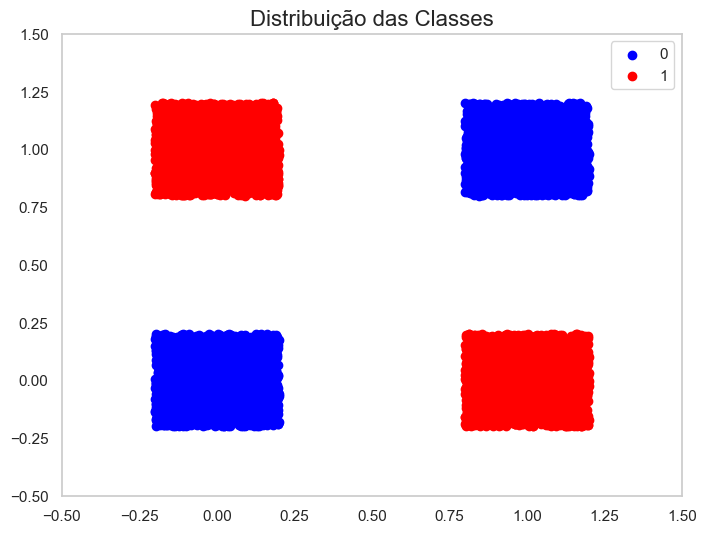

In [77]:
classes = data['y'].unique()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for classe in classes:
    valores = data[data['y'] == classe].values
    x,y = valores[:,0] , valores[:,1]
    ax.scatter(x,y, label=classe, color='blue' if classe == 0 else 'red')

ax.set_title("Distribuição das Classes", fontsize=16)
ax.grid()
ax.set_xlim(-.5, 1.5)
ax.set_ylim(-.5, 1.5)
ax.legend(loc="best");

##### Preparando os dados

In [78]:
X = torch.tensor(data[['x1', 'x2']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.long)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Criando a Rede Neural

In [80]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=32,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=32,
        shuffle=True
    )
}

In [81]:
class NeuralNet_a(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_a, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_stack(x)

In [82]:
model = NeuralNet_a(2, 7, 1)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

##### Usando SGD como otimizador

In [83]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

epochs = 100

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.round() == target).float().mean()
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            target = target.unsqueeze(1)
            target = target.float()
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(loaders['test'].dataset)

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(test_loss)
    test_acc_hist.append(correct / len(loaders['test'].dataset))

    if (correct / len(loaders['test'].dataset) >= 0.996) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 120:
        if (np.mean(test_acc_hist[-60:]) <= np.mean(test_acc_hist[-120:-60])) or (len(set(test_acc_hist[-50:])) == 1):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n")

Epoch [6/100]:   5%|██▍                                           | 1044/20000 [00:04<01:21, 232.15it/s, loss=0.645977]

 Test set: Average loss: 0.0203, Accuracy: 1112/1600 (69.50%)



Epoch [11/100]:  10%|████▌                                        | 2045/20000 [00:08<01:12, 246.75it/s, loss=0.587027]

 Test set: Average loss: 0.0182, Accuracy: 1158/1600 (72.38%)



Epoch [16/100]:  15%|██████▊                                      | 3044/20000 [00:13<01:09, 245.31it/s, loss=0.519523]

 Test set: Average loss: 0.0158, Accuracy: 1192/1600 (74.50%)



Epoch [21/100]:  20%|█████████                                    | 4041/20000 [00:17<01:12, 219.64it/s, loss=0.415676]

 Test set: Average loss: 0.0126, Accuracy: 1487/1600 (92.94%)



Epoch [26/100]:  25%|███████████▎                                 | 5027/20000 [00:22<01:42, 145.62it/s, loss=0.240106]

 Test set: Average loss: 0.0090, Accuracy: 1593/1600 (99.56%)



Epoch [30/100]:  30%|█████████████▍                               | 5999/20000 [00:27<01:14, 189.20it/s, loss=0.208912]


Accuracy on epoch 30 = 100%. Finishing training...

Accuracy: 1600/1600 (100.00%)



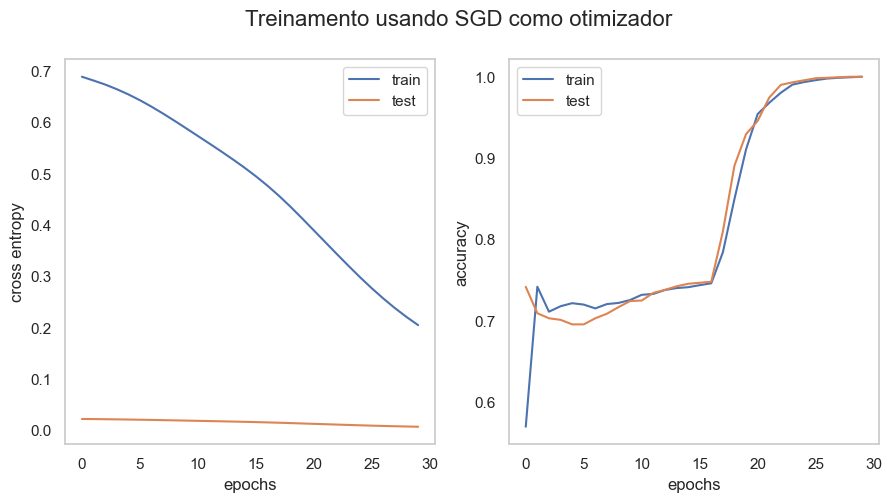

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 5))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].grid();
fig.suptitle("Treinamento usando SGD como otimizador", fontsize=16);

In [85]:
xx, yy = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(-.5, 1.5, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid_points)

In [86]:
with torch.no_grad():
    model.eval()
    predictions = model(grid_tensor).numpy()

limit = 0.5
class_pred = (predictions > limit).astype(int)


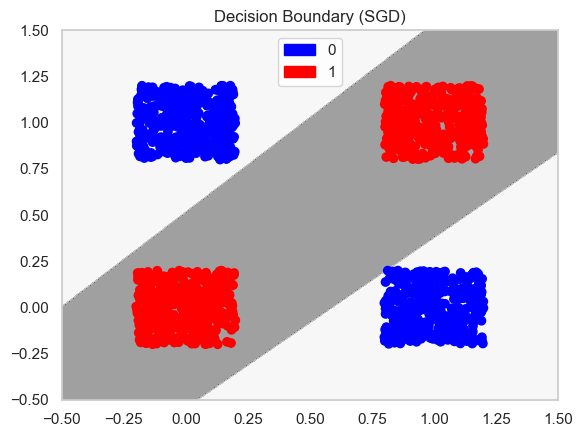

In [90]:
plt.contourf(xx, yy, class_pred.reshape(xx.shape), alpha=.4, cmap='gray')
plt.scatter(X_test.numpy()[:, 0], X_test.numpy()[:, 1], c=['blue' if i == 1 else 'red' for i in y_test])
plt.title('Decision Boundary (SGD)')
red_patch = mpatches.Patch(color='blue', label='0')
green_patch = mpatches.Patch(color='red', label='1')
plt.legend(handles=[red_patch, green_patch], loc='upper center')
plt.xlim(-.5, 1.5)
plt.ylim(-.5, 1.5)
plt.grid()

##### Usando Adam como otimizador

In [16]:
model2 = NeuralNet_a(2, 7, 1)
optimizer = optim.Adam(model2.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

In [17]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

epochs = 100

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.round() == target).float().mean()
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model2(data)
            target = target.unsqueeze(1)
            target = target.float()
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(loaders['test'].dataset)

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(test_loss)
    test_acc_hist.append(correct / len(loaders['test'].dataset))

    if (correct / len(loaders['test'].dataset) >= 0.99) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 120:
        if (np.mean(test_acc_hist[-60:]) <= np.mean(test_acc_hist[-120:-60])) or (len(set(test_acc_hist[-50:])) == 1):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n")


Epoch [20/100]:  20%|█████████                                    | 4000/20000 [00:29<01:59, 133.91it/s, loss=0.256813]

Epoch [1/100]:   0%|                                                 | 30/20000 [00:00<05:11, 64.17it/s, loss=0.632423]


Epoch [1/100]:   0%|▏                                                | 61/20000 [00:00<05:16, 62.99it/s, loss=0.542489]


Epoch [1/100]:   0%|▏                                                | 92/20000 [00:01<04:46, 69.58it/s, loss=0.425498]


Epoch [1/100]:   1%|▎                                               | 123/20000 [00:01<04:48, 68.90it/s, loss=0.248407]


Epoch [1/100]:   1%|▎                                               | 153/20000 [00:02<04:47, 69.02it/s, loss=0.125310]


Epoch [1/100]:   1%|▍                                               | 184/20000 [00:02<04:42, 70.27it/s, loss=0.077885]


Epoch [2/100]:   1%|▌                                               | 216/20000 [00:03<05:03, 65.13it/s, loss=0.036341]


Epoch [2/100]:   1%|▌                                               | 246/20000 [00:03<04:50, 68.06it/s, loss=0.032216]


Epoch [2/100]:   1%|▋                                               | 278/20000 [00:04<05:02, 65.22it/s, loss=0.020497]


Epoch [2/100]:   2%|▋                                               | 309/20000 [00:04<04:39, 70.50it/s, loss=0.013479]


Epoch [2/100]:   2%|▊                                               | 340/20000 [00:05<04:46, 68.72it/s, loss=0.015632]


Epoch [2/100]:   2%|▉                                               | 371/20000 [00:05<04:38, 70.47it/s, loss=0.010322]


Epoch [3/100]:   2%|▉                                               | 402/20000 [00:05<04:13, 77.38it/s, loss=0.011837]


Epoch [3/100]:   2%|█                                               | 433/20000 [00:06<04:48, 67.72it/s, loss=0.008612]


Epoch [3/100]:   2%|█                                               | 464/20000 [00:06<04:35, 70.85it/s, loss=0.005156]


Epoch [3/100]:   2%|█▏                                              | 495/20000 [00:07<04:19, 75.31it/s, loss=0.006857]


Epoch [3/100]:   3%|█▎                                              | 526/20000 [00:07<04:15, 76.17it/s, loss=0.005418]


Epoch [3/100]:   3%|█▎                                              | 557/20000 [00:07<03:55, 82.67it/s, loss=0.006192]


Epoch [3/100]:   3%|█▍                                              | 589/20000 [00:08<03:57, 81.70it/s, loss=0.004201]


Epoch [4/100]:   3%|█▍                                              | 620/20000 [00:08<04:04, 79.13it/s, loss=0.005343]


Epoch [4/100]:   3%|█▌                                              | 651/20000 [00:09<04:12, 76.55it/s, loss=0.003981]


Epoch [4/100]:   3%|█▋                                              | 682/20000 [00:09<04:05, 78.83it/s, loss=0.004479]


Epoch [4/100]:   4%|█▋                                              | 714/20000 [00:09<03:49, 84.16it/s, loss=0.003822]


Epoch [4/100]:   4%|█▊                                              | 745/20000 [00:10<04:11, 76.55it/s, loss=0.002786]


Epoch [4/100]:   4%|█▊                                              | 776/20000 [00:10<04:23, 72.98it/s, loss=0.002654]


Epoch [5/100]:   4%|█▉                                              | 807/20000 [00:11<05:00, 63.86it/s, loss=0.002699]


Epoch [5/100]:   4%|██                                              | 838/20000 [00:11<04:35, 69.58it/s, loss=0.002384]


Epoch [5/100]:   4%|██                                              | 869/20000 [00:12<04:32, 70.16it/s, loss=0.002696]


Epoch [5/100]:   4%|██▏                                             | 900/20000 [00:12<04:30, 70.68it/s, loss=0.002342]


Epoch [5/100]:   5%|██▏                                             | 931/20000 [00:12<04:24, 72.12it/s, loss=0.002470]


Epoch [5/100]:   5%|██▎                                             | 962/20000 [00:13<04:24, 71.94it/s, loss=0.001741]


Epoch [5/100]:   5%|██▍                                             | 993/20000 [00:13<04:22, 72.45it/s, loss=0.001518]


Epoch [6/100]:   5%|██▍                                            | 1012/20000 [00:14<04:48, 65.87it/s, loss=0.001747]

 Test set: Average loss: 0.0001, Accuracy: 1600/1600 (100%)




Epoch [6/100]:   5%|██▍                                            | 1043/20000 [00:14<04:27, 70.95it/s, loss=0.001131]


Epoch [6/100]:   5%|██▌                                            | 1074/20000 [00:15<04:33, 69.14it/s, loss=0.001607]


Epoch [6/100]:   6%|██▌                                            | 1105/20000 [00:15<04:23, 71.69it/s, loss=0.001781]


Epoch [6/100]:   6%|██▋                                            | 1136/20000 [00:15<04:35, 68.52it/s, loss=0.001026]


Epoch [6/100]:   6%|██▋                                            | 1167/20000 [00:16<03:57, 79.39it/s, loss=0.001192]


Epoch [6/100]:   6%|██▊                                            | 1198/20000 [00:16<03:52, 81.03it/s, loss=0.001493]


Epoch [7/100]:   6%|██▉                                            | 1229/20000 [00:17<03:52, 80.67it/s, loss=0.001377]


Epoch [7/100]:   6%|██▉                                            | 1261/20000 [00:17<03:44, 83.34it/s, loss=0.000867]


Epoch [7/100]:   6%|███                                            | 1292/20000 [00:17<03:43, 83.76it/s, loss=0.001275]


Epoch [7/100]:   7%|███                                            | 1323/20000 [00:18<03:44, 83.22it/s, loss=0.001107]


Epoch [7/100]:   7%|███▏                                           | 1355/20000 [00:18<03:37, 85.85it/s, loss=0.000618]


Epoch [7/100]:   7%|███▎                                           | 1386/20000 [00:18<03:38, 85.23it/s, loss=0.001029]


Epoch [8/100]:   7%|███▎                                           | 1417/20000 [00:19<03:56, 78.45it/s, loss=0.000612]


Epoch [8/100]:   7%|███▍                                           | 1448/20000 [00:19<03:49, 80.74it/s, loss=0.000659]


Epoch [8/100]:   7%|███▍                                           | 1479/20000 [00:20<04:16, 72.32it/s, loss=0.000694]


Epoch [8/100]:   8%|███▌                                           | 1511/20000 [00:20<04:22, 70.37it/s, loss=0.001029]


Epoch [8/100]:   8%|███▌                                           | 1542/20000 [00:21<04:23, 70.00it/s, loss=0.000873]


Epoch [8/100]:   8%|███▋                                           | 1573/20000 [00:21<04:36, 66.72it/s, loss=0.000561]


Epoch [9/100]:   8%|███▊                                           | 1604/20000 [00:21<04:17, 71.33it/s, loss=0.000588]


Epoch [9/100]:   8%|███▊                                           | 1635/20000 [00:22<04:18, 70.92it/s, loss=0.000560]


Epoch [9/100]:   8%|███▉                                           | 1666/20000 [00:22<04:17, 71.18it/s, loss=0.000554]


Epoch [9/100]:   8%|███▉                                           | 1697/20000 [00:23<04:18, 70.80it/s, loss=0.000399]


Epoch [9/100]:   9%|████                                           | 1728/20000 [00:23<04:17, 70.95it/s, loss=0.000733]


Epoch [9/100]:   9%|████▏                                          | 1759/20000 [00:24<04:00, 75.85it/s, loss=0.000556]


Epoch [9/100]:   9%|████▏                                          | 1790/20000 [00:24<04:05, 74.24it/s, loss=0.000553]


Epoch [10/100]:   9%|████▏                                         | 1821/20000 [00:25<04:29, 67.49it/s, loss=0.000646]


Epoch [10/100]:   9%|████▎                                         | 1852/20000 [00:25<04:12, 71.90it/s, loss=0.000474]


Epoch [10/100]:   9%|████▎                                         | 1883/20000 [00:25<04:03, 74.45it/s, loss=0.000931]


Epoch [10/100]:  10%|████▍                                         | 1914/20000 [00:26<04:18, 69.88it/s, loss=0.000383]


Epoch [10/100]:  10%|████▍                                         | 1945/20000 [00:26<04:03, 74.04it/s, loss=0.000518]


Epoch [10/100]:  10%|████▌                                         | 1976/20000 [00:27<04:03, 74.14it/s, loss=0.000433]


Epoch [10/100]:  10%|████▌                                         | 1999/20000 [00:27<04:06, 73.14it/s, loss=0.000429]


Accuracy on epoch 10 = 100%. Finishing training...

Accuracy: 1600/1600 (100%)



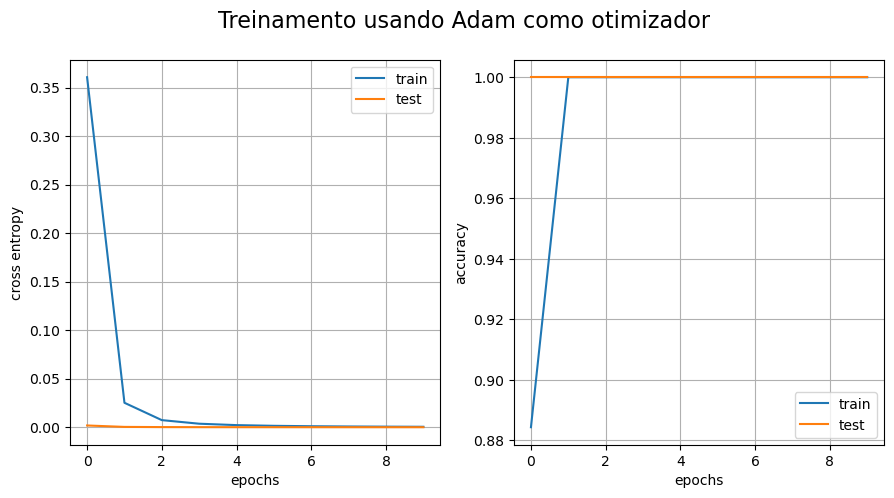

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 5))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].grid();
fig.suptitle("Treinamento usando Adam como otimizador", fontsize=16);

In [19]:
model2.eval()
with torch.no_grad():
    output = model2(torch.Tensor([[0, 0], [1, 1], [0, 1], [1, 0]]))
    print(output.round())


tensor([[0.],
        [0.],
        [1.],
        [1.]])


In [20]:
xx, yy = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(-.5, 1.5, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid_points)

In [21]:
with torch.no_grad():
    model2.eval()
    predictions = model2(grid_tensor).numpy()

limit = 0.5
class_pred = (predictions > limit).astype(int)


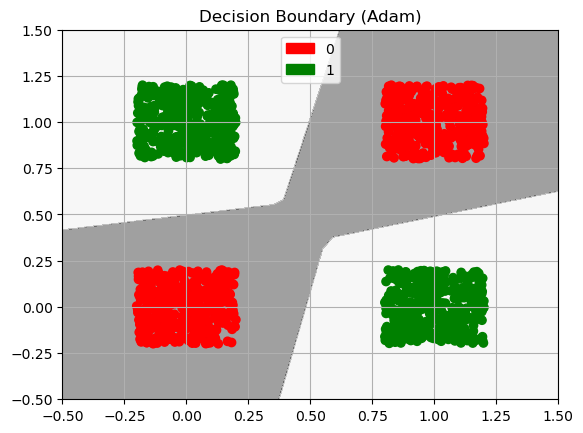

In [22]:
plt.contourf(xx, yy, class_pred.reshape(xx.shape), alpha=.4, cmap='gray')
plt.scatter(X_test.numpy()[:, 0], X_test.numpy()[:, 1], c=['green' if i == 1 else 'red' for i in y_test])
plt.title('Decision Boundary (Adam)')
red_patch = mpatches.Patch(color='red', label='0')
green_patch = mpatches.Patch(color='green', label='1')
plt.legend(handles=[red_patch, green_patch], loc='upper center')
plt.xlim(-.5, 1.5)
plt.ylim(-.5, 1.5)
plt.grid()

### b) $f(x) = log_{10}(x), 1 \leq x \leq 10$

#### Criando o dataset

In [23]:
X = np.linspace(1, 10, 4000)
y = np.log10(X)

In [24]:
data = pd.DataFrame([X, y]).T
data.columns = ['X', 'y']
data

X         y
0      1.000000  0.000000
1      1.002251  0.000976
2      1.004501  0.001950
3      1.006752  0.002922
4      1.009002  0.003892
...         ...       ...
3995   9.990998  0.999609
3996   9.993248  0.999707
3997   9.995499  0.999804
3998   9.997749  0.999902
3999  10.000000  1.000000

[4000 rows x 2 columns]

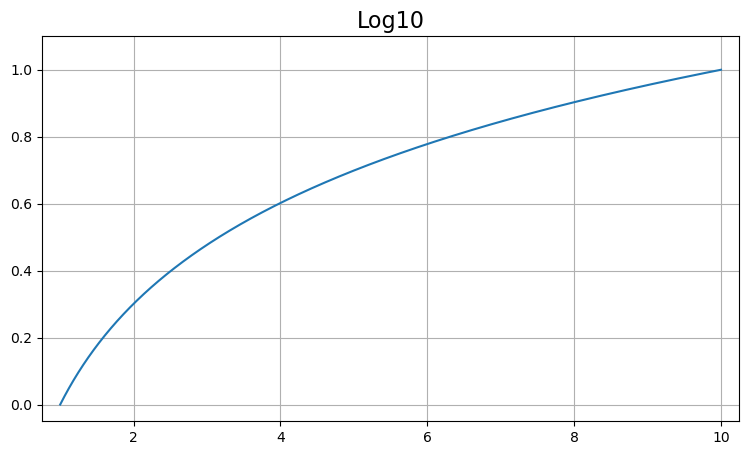

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(data['X'], data['y'])
plt.xlim(.75, 10.25)
plt.ylim(-0.05, 1.1)
plt.grid()
plt.title('Log10', fontsize=16);

#### Criando a Rede Neural

In [26]:
X = torch.tensor(data[['X']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.float32)

In [27]:
class NeuralNet_b(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_b, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

##### Abordagem 2 (Usando como teste os 20% finais do dataset)

In [28]:
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(y)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(y)*.8):]

In [29]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=32,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=32,
        shuffle=True
    )
}

In [30]:
model2 = NeuralNet_b(1, 10, 1)
optimizer = optim.Adam(model2.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

In [31]:
train_loss_hist = []
test_loss_hist = []

epochs = 100

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    test_loss = []
    epoch_loss = []
    epoch_acc = []

    model2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)

    model2.eval()
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model2(data)
            mse = float(loss_fn(output, target))
            test_loss.append(mse)

    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(np.mean(test_loss))

    if epoch > 120:
        if np.mean(test_loss_hist[-60:]) <= np.mean(test_loss_hist[-120:-60]):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}") if epoch % 5 == 0 else None

Epoch [6/100]:   5%|██▍                                            | 520/10000 [00:04<01:26, 110.23it/s, loss=0.000257]

 Test set: Average loss: 0.0038


Epoch [11/100]:  10%|████▌                                        | 1022/10000 [00:08<01:15, 118.83it/s, loss=0.000347]

 Test set: Average loss: 0.0038


Epoch [16/100]:  15%|██████▊                                      | 1523/10000 [00:12<01:05, 129.98it/s, loss=0.000393]

 Test set: Average loss: 0.0036


Epoch [21/100]:  20%|█████████                                    | 2020/10000 [00:17<01:15, 105.38it/s, loss=0.000282]

 Test set: Average loss: 0.0029


Epoch [26/100]:  25%|███████████▎                                 | 2527/10000 [00:21<01:02, 119.12it/s, loss=0.000102]

 Test set: Average loss: 0.0021


Epoch [31/100]:  30%|█████████████▌                               | 3020/10000 [00:25<01:01, 113.93it/s, loss=0.000038]

 Test set: Average loss: 0.0013


Epoch [36/100]:  35%|███████████████▊                             | 3521/10000 [00:29<00:57, 113.06it/s, loss=0.000009]

 Test set: Average loss: 0.0012


Epoch [41/100]:  40%|██████████████████                           | 4023/10000 [00:34<00:48, 122.61it/s, loss=0.000003]

 Test set: Average loss: 0.0011


Epoch [46/100]:  45%|████████████████████▍                        | 4532/10000 [00:37<00:37, 145.82it/s, loss=0.000004]

 Test set: Average loss: 0.0011


Epoch [51/100]:  50%|██████████████████████▌                      | 5021/10000 [00:41<00:41, 118.73it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [56/100]:  55%|████████████████████████▊                    | 5519/10000 [00:45<00:37, 119.60it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [61/100]:  60%|███████████████████████████                  | 6025/10000 [00:49<00:30, 130.83it/s, loss=0.000003]

 Test set: Average loss: 0.0011


Epoch [66/100]:  65%|█████████████████████████████▎               | 6525/10000 [00:53<00:26, 130.71it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [71/100]:  70%|███████████████████████████████▌             | 7023/10000 [00:57<00:22, 131.45it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [76/100]:  75%|█████████████████████████████████▊           | 7523/10000 [01:01<00:18, 133.44it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [81/100]:  80%|████████████████████████████████████         | 8024/10000 [01:04<00:14, 136.77it/s, loss=0.000000]

 Test set: Average loss: 0.0011


Epoch [86/100]:  85%|██████████████████████████████████████▎      | 8526/10000 [01:08<00:10, 136.41it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [91/100]:  90%|████████████████████████████████████████▌    | 9024/10000 [01:12<00:07, 135.01it/s, loss=0.000001]

 Test set: Average loss: 0.0011


Epoch [96/100]:  95%|██████████████████████████████████████████▊  | 9523/10000 [01:16<00:03, 128.79it/s, loss=0.000002]

 Test set: Average loss: 0.0011


Epoch [100/100]: 100%|███████████████████████████████████████████▉| 9999/10000 [01:19<00:00, 139.42it/s, loss=0.000002]

 Test set: Average loss: 0.0011


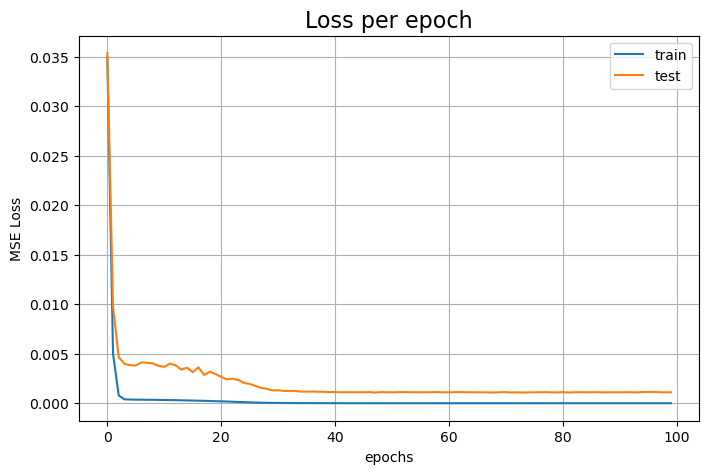

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.title("Loss per epoch", fontsize=16)
plt.legend()
plt.grid();

In [33]:
model2.eval()
with torch.no_grad():
    output = model2(X_test)

(0.75, 10.25)

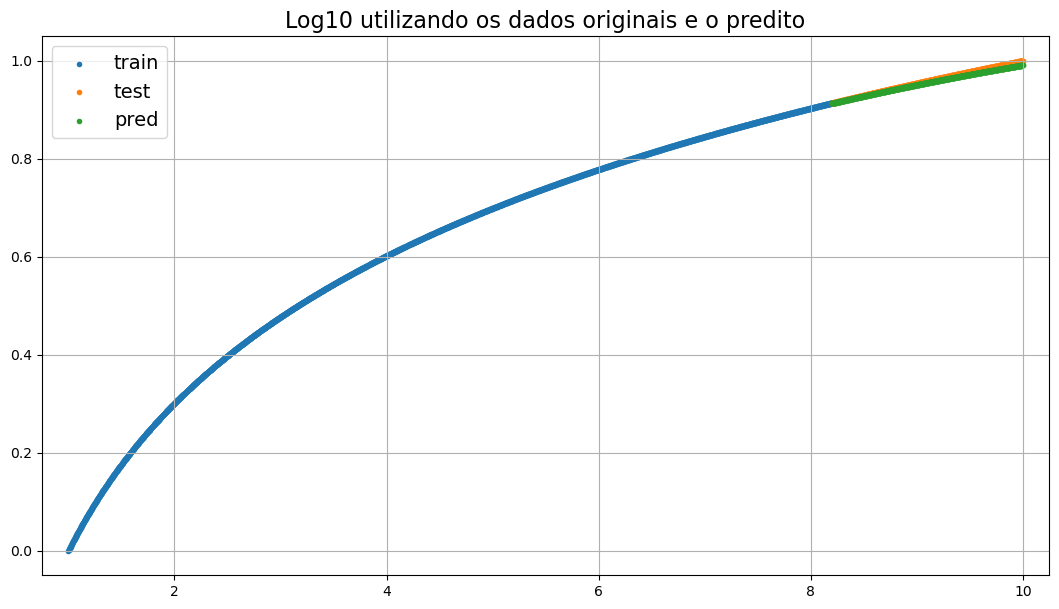

In [34]:
plt.figure(figsize=(13, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='pred', marker='.')
plt.grid()
plt.title('Log10 utilizando os dados originais e o predito', fontsize=16)
plt.legend(fontsize='14')
plt.xlim(.75, 10.25)

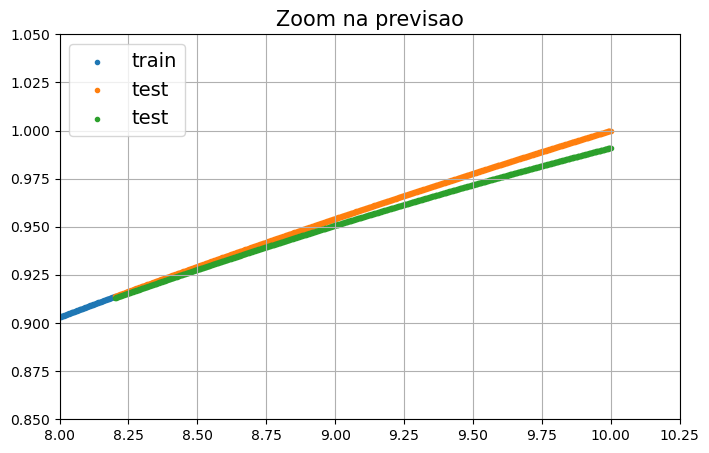

In [35]:
plt.figure(figsize=(8, 5))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='test', marker='.')
plt.grid()
plt.title('Zoom na previsao', fontsize=15)
plt.legend(fontsize='14')
plt.xlim(8, 10.25)
plt.ylim(0.85, 1.05);

In [36]:
# RMSE
torch.sqrt(loss_fn(output, y_test))

tensor(0.0338)

### c) $f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2, 0 \leq x \leq 8$

#### Criando o dataset

In [37]:
def f(x):
    return (10*(x**5)) + (5*(x**4)) + (2*(x**3)) - (0.5*(x**2)) + (3*x) + 2

In [38]:
X = np.linspace(0, 8, 4000)
y = f(X)

In [39]:
data = pd.DataFrame([X, y]).T
data.columns = ['X', 'y']
data

X              y
0     0.000000       2.000000
1     0.002001       2.006000
2     0.004001       2.011995
3     0.006002       2.017987
4     0.008002       2.023975
...        ...            ...
3995  7.991998  347457.618116
3996  7.993998  347887.076360
3997  7.995999  348316.959212
3998  7.997999  348747.266987
3999  8.000000  349178.000000

[4000 rows x 2 columns]

Text(0.5, 1.0, 'f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')

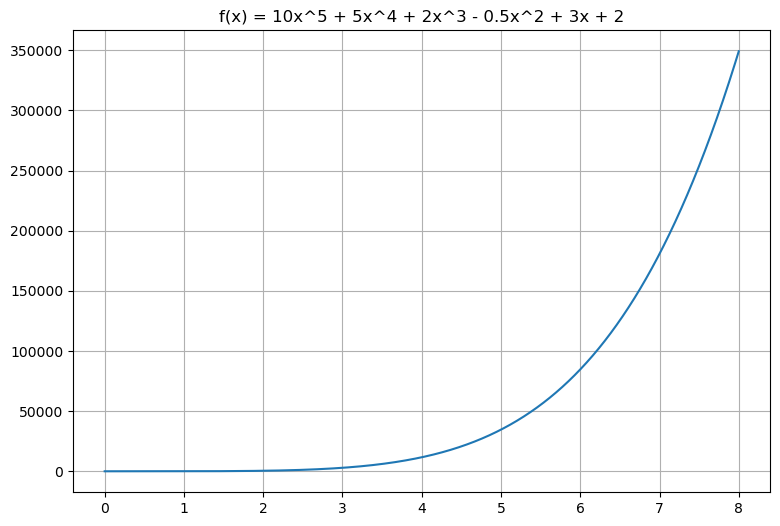

In [40]:
plt.figure(figsize=(9, 6))
plt.plot(data['X'], data['y'])
plt.grid()
plt.title("f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2")

#### Criando a Rede Neural

In [41]:
X = torch.tensor(data[['X']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.float32)

In [42]:
class NeuralNet_c1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_c1, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

#####  Usando como teste os 20% finais do dataset

In [43]:
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(y)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(y)*.8):]

In [44]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=64,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=64,
        shuffle=True
    )
}

In [45]:
model_c2 = NeuralNet_c1(1, [32, 16, 32], 1)
optimizer = optim.Adam(model_c2.parameters(), lr=0.2)
loss_fn = nn.MSELoss()

In [46]:
for param in model_c2.parameters():
    param.data.uniform_(-1, 1)

In [47]:
train_loss_hist = []
test_loss_hist = []

epochs = 250

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    test_loss = []
    epoch_loss = []
    epoch_acc = []

    model_c2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model_c2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)

    model_c2.eval()
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model_c2(data)
            mse = float(loss_fn(output, target))
            test_loss.append(mse)

    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(np.mean(test_loss))

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}") if epoch % 5 == 0 else None


Epoch [100/100]: 100%|███████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.86it/s, loss=0.000002]

Epoch [1/250]:   0%|                                         | 30/12500 [00:00<03:02, 68.38it/s, loss=449372096.000000]


Epoch [2/250]:   0%|▏                                         | 61/12500 [00:00<02:58, 69.52it/s, loss=48039496.000000]


Epoch [2/250]:   1%|▎                                         | 92/12500 [00:01<03:01, 68.38it/s, loss=23804404.000000]


Epoch [3/250]:   1%|▍                                         | 123/12500 [00:01<03:09, 65.43it/s, loss=8855869.000000]


Epoch [4/250]:   1%|▌                                          | 153/12500 [00:02<03:31, 58.51it/s, loss=940482.750000]


Epoch [4/250]:   1%|▌                                         | 184/12500 [00:02<03:06, 65.97it/s, loss=1320728.250000]


Epoch [5/250]:   2%|▋                                         | 215/12500 [00:03<03:10, 64.64it/s, loss=2611195.500000]


Epoch [5/250]:   2%|▊                                         | 246/12500 [00:03<03:03, 66.64it/s, loss=7237208.500000]


Epoch [6/250]:   2%|▉                                         | 262/12500 [00:03<03:01, 67.41it/s, loss=7670326.500000]

 Test set: Average loss: 7115600817.2308



Epoch [6/250]:   2%|█                                          | 293/12500 [00:04<02:56, 69.16it/s, loss=345089.687500]


Epoch [7/250]:   3%|█                                         | 324/12500 [00:04<02:57, 68.77it/s, loss=8267343.000000]


Epoch [8/250]:   3%|█▏                                         | 355/12500 [00:05<03:09, 64.06it/s, loss=916105.750000]


Epoch [8/250]:   3%|█▎                                        | 386/12500 [00:05<03:05, 65.30it/s, loss=1490034.000000]


Epoch [9/250]:   3%|█▍                                         | 416/12500 [00:06<03:11, 63.17it/s, loss=342261.031250]


Epoch [9/250]:   4%|█▌                                         | 447/12500 [00:06<03:22, 59.50it/s, loss=262109.031250]


Epoch [10/250]:   4%|█▌                                        | 478/12500 [00:07<03:01, 66.10it/s, loss=817211.062500]


Epoch [11/250]:   4%|█▋                                        | 509/12500 [00:07<03:02, 65.82it/s, loss=347098.250000]


Epoch [11/250]:   4%|█▋                                        | 511/12500 [00:07<03:02, 65.82it/s, loss=170218.859375]

 Test set: Average loss: 7833823310.7692



Epoch [11/250]:   4%|█▊                                        | 542/12500 [00:08<02:54, 68.55it/s, loss=309896.406250]


Epoch [12/250]:   5%|█▉                                       | 573/12500 [00:08<02:57, 67.02it/s, loss=7714838.500000]


Epoch [13/250]:   5%|█▉                                      | 604/12500 [00:09<03:06, 63.91it/s, loss=61959860.000000]


Epoch [13/250]:   5%|██                                       | 635/12500 [00:09<02:56, 67.38it/s, loss=7666588.000000]


Epoch [14/250]:   5%|██▏                                      | 666/12500 [00:10<03:02, 64.87it/s, loss=7551683.000000]


Epoch [14/250]:   6%|██▎                                       | 696/12500 [00:10<03:01, 64.88it/s, loss=349715.312500]


Epoch [15/250]:   6%|██▍                                       | 727/12500 [00:11<02:54, 67.66it/s, loss=726471.312500]


Epoch [16/250]:   6%|██▌                                       | 758/12500 [00:11<02:59, 65.34it/s, loss=282817.781250]


Epoch [16/250]:   6%|██▌                                       | 761/12500 [00:11<02:58, 65.77it/s, loss=500759.093750]


 Test set: Average loss: 7955399483.0769


Epoch [16/250]:   6%|██▋                                       | 792/12500 [00:12<02:43, 71.48it/s, loss=447684.875000]


Epoch [17/250]:   7%|██▊                                       | 823/12500 [00:12<02:52, 67.53it/s, loss=241010.078125]


Epoch [18/250]:   7%|██▊                                       | 854/12500 [00:12<02:52, 67.50it/s, loss=284909.281250]


Epoch [18/250]:   7%|██▉                                       | 885/12500 [00:13<02:43, 70.88it/s, loss=231989.812500]


Epoch [19/250]:   7%|███                                       | 916/12500 [00:13<02:41, 71.82it/s, loss=158262.375000]


Epoch [19/250]:   8%|███▏                                      | 947/12500 [00:14<02:52, 66.85it/s, loss=246679.312500]


Epoch [20/250]:   8%|███▎                                      | 978/12500 [00:14<02:54, 66.03it/s, loss=271294.000000]


Epoch [21/250]:   8%|███▎                                     | 1009/12500 [00:15<03:23, 56.54it/s, loss=376242.281250]


Epoch [21/250]:   8%|███▎                                     | 1010/12500 [00:15<03:23, 56.54it/s, loss=209719.500000]

 Test set: Average loss: 7442650269.5385



Epoch [21/250]:   8%|███▍                                     | 1041/12500 [00:15<03:08, 60.92it/s, loss=180103.734375]


Epoch [22/250]:   9%|███▌                                     | 1072/12500 [00:16<03:04, 62.09it/s, loss=170707.234375]


Epoch [23/250]:   9%|███▌                                     | 1103/12500 [00:16<02:49, 67.36it/s, loss=490195.937500]


Epoch [23/250]:   9%|███▋                                     | 1133/12500 [00:17<02:52, 65.93it/s, loss=221651.515625]


Epoch [24/250]:   9%|███▋                                    | 1164/12500 [00:17<02:46, 68.06it/s, loss=1469380.000000]


Epoch [24/250]:  10%|███▉                                     | 1195/12500 [00:18<02:40, 70.40it/s, loss=238059.703125]


Epoch [25/250]:  10%|███▉                                    | 1226/12500 [00:18<02:40, 70.04it/s, loss=3037465.750000]


Epoch [26/250]:  10%|████                                    | 1258/12500 [00:19<02:46, 67.42it/s, loss=2460356.750000]


Epoch [26/250]:  10%|████▏                                    | 1261/12500 [00:19<02:46, 67.42it/s, loss=515026.843750]

 Test set: Average loss: 7504000236.3077



Epoch [26/250]:  10%|████▏                                   | 1292/12500 [00:19<02:48, 66.62it/s, loss=2374823.000000]


Epoch [27/250]:  11%|████▏                                   | 1322/12500 [00:20<02:50, 65.71it/s, loss=1941137.750000]


Epoch [28/250]:  11%|████▍                                    | 1353/12500 [00:20<02:45, 67.54it/s, loss=355905.093750]


Epoch [28/250]:  11%|████▌                                    | 1384/12500 [00:20<02:35, 71.28it/s, loss=203254.281250]


Epoch [29/250]:  11%|████▌                                   | 1415/12500 [00:21<02:42, 68.26it/s, loss=2155510.750000]


Epoch [29/250]:  12%|████▋                                    | 1446/12500 [00:21<02:41, 68.61it/s, loss=742014.250000]


Epoch [30/250]:  12%|████▋                                   | 1477/12500 [00:22<02:38, 69.50it/s, loss=1097769.750000]


Epoch [31/250]:  12%|████▉                                    | 1508/12500 [00:22<02:36, 70.03it/s, loss=634044.125000]


Epoch [31/250]:  12%|████▊                                   | 1513/12500 [00:22<02:33, 71.76it/s, loss=1300889.250000]

 Test set: Average loss: 7684113683.6923



Epoch [31/250]:  12%|█████                                    | 1545/12500 [00:23<02:31, 72.44it/s, loss=276099.531250]


Epoch [32/250]:  13%|█████▏                                   | 1576/12500 [00:23<02:34, 70.74it/s, loss=857303.312500]


Epoch [33/250]:  13%|█████▎                                   | 1607/12500 [00:24<02:44, 66.13it/s, loss=675423.375000]


Epoch [33/250]:  13%|█████▎                                   | 1637/12500 [00:24<02:39, 67.96it/s, loss=340420.281250]


Epoch [34/250]:  13%|█████▍                                   | 1668/12500 [00:25<02:38, 68.38it/s, loss=195004.671875]


Epoch [34/250]:  14%|█████▌                                   | 1699/12500 [00:25<02:37, 68.48it/s, loss=146862.000000]


Epoch [35/250]:  14%|█████▋                                   | 1730/12500 [00:26<02:42, 66.14it/s, loss=479266.406250]


Epoch [36/250]:  14%|█████▊                                   | 1761/12500 [00:26<02:50, 62.84it/s, loss=503483.062500]


Epoch [36/250]:  14%|█████▉                                    | 1761/12500 [00:26<02:50, 62.84it/s, loss=79187.281250]

 Test set: Average loss: 7313977659.0769



Epoch [36/250]:  14%|██████                                    | 1792/12500 [00:26<02:41, 66.13it/s, loss=67323.054688]


Epoch [37/250]:  15%|█████▉                                   | 1823/12500 [00:27<02:40, 66.52it/s, loss=821096.000000]


Epoch [38/250]:  15%|██████                                   | 1854/12500 [00:27<02:40, 66.23it/s, loss=114737.648438]


Epoch [38/250]:  15%|██████▏                                  | 1885/12500 [00:28<02:37, 67.26it/s, loss=516439.406250]


Epoch [39/250]:  15%|██████▎                                  | 1916/12500 [00:28<02:40, 66.07it/s, loss=141719.046875]


Epoch [39/250]:  16%|██████▍                                  | 1947/12500 [00:29<02:32, 69.15it/s, loss=126381.203125]


Epoch [40/250]:  16%|██████▍                                  | 1978/12500 [00:29<02:29, 70.27it/s, loss=565724.875000]


Epoch [41/250]:  16%|██████▌                                  | 2009/12500 [00:30<02:35, 67.62it/s, loss=197689.921875]


Epoch [41/250]:  16%|██████▌                                  | 2011/12500 [00:30<02:35, 67.62it/s, loss=567810.500000]


 Test set: Average loss: 7185112851.6923


Epoch [41/250]:  16%|██████▌                                 | 2042/12500 [00:30<02:29, 70.03it/s, loss=3276668.750000]


Epoch [42/250]:  17%|██████▊                                  | 2073/12500 [00:31<02:45, 62.83it/s, loss=138363.031250]


Epoch [43/250]:  17%|██████▉                                  | 2104/12500 [00:31<02:50, 61.13it/s, loss=143168.968750]


Epoch [43/250]:  17%|███████▏                                  | 2135/12500 [00:32<02:44, 63.02it/s, loss=97695.429688]


Epoch [44/250]:  17%|███████                                  | 2165/12500 [00:32<03:04, 55.89it/s, loss=134843.531250]


Epoch [44/250]:  18%|███████                                 | 2196/12500 [00:33<02:39, 64.73it/s, loss=5626543.500000]


Epoch [45/250]:  18%|██████▉                                | 2227/12500 [00:33<02:38, 64.79it/s, loss=18271696.000000]


Epoch [46/250]:  18%|███████▏                                | 2258/12500 [00:34<02:47, 61.09it/s, loss=1914386.500000]


Epoch [46/250]:  18%|███████▏                                | 2261/12500 [00:34<02:44, 62.38it/s, loss=5027412.500000]

 Test set: Average loss: 10110411382.1538



Epoch [46/250]:  18%|███████▌                                 | 2291/12500 [00:34<02:31, 67.45it/s, loss=305196.281250]


Epoch [47/250]:  19%|███████▍                                | 2322/12500 [00:35<02:31, 67.30it/s, loss=1283122.000000]


Epoch [48/250]:  19%|███████▌                                | 2353/12500 [00:35<02:30, 67.62it/s, loss=1014366.312500]


Epoch [48/250]:  19%|███████▋                                | 2384/12500 [00:36<02:43, 61.91it/s, loss=1931246.875000]


Epoch [49/250]:  19%|███████▉                                 | 2415/12500 [00:36<03:02, 55.39it/s, loss=444397.312500]


Epoch [49/250]:  20%|███████▊                                | 2445/12500 [00:37<02:57, 56.73it/s, loss=2506016.000000]


Epoch [50/250]:  20%|███████▉                                | 2476/12500 [00:37<02:55, 56.99it/s, loss=3097317.500000]


Epoch [51/250]:  20%|███████▊                               | 2506/12500 [00:38<03:00, 55.30it/s, loss=10905114.000000]


Epoch [51/250]:  20%|███████▊                               | 2510/12500 [00:38<02:57, 56.34it/s, loss=10922429.000000]

 Test set: Average loss: 7097610594.4615



Epoch [51/250]:  20%|████████▏                               | 2541/12500 [00:38<02:49, 58.77it/s, loss=1596679.250000]


Epoch [52/250]:  21%|████████▍                                | 2571/12500 [00:39<02:58, 55.57it/s, loss=109751.296875]


Epoch [53/250]:  21%|████████▌                                | 2602/12500 [00:39<02:43, 60.44it/s, loss=749579.250000]


Epoch [53/250]:  21%|████████▋                                | 2632/12500 [00:40<02:53, 57.02it/s, loss=110024.062500]


Epoch [54/250]:  21%|████████▋                                | 2663/12500 [00:40<02:56, 55.69it/s, loss=147860.828125]


Epoch [54/250]:  22%|████████▊                                | 2694/12500 [00:41<02:43, 60.14it/s, loss=125587.328125]


Epoch [55/250]:  22%|████████▉                                | 2724/12500 [00:41<02:45, 59.08it/s, loss=235994.625000]


Epoch [56/250]:  22%|█████████                                | 2755/12500 [00:42<02:45, 59.03it/s, loss=397465.812500]


Epoch [56/250]:  22%|█████████                                | 2760/12500 [00:42<02:39, 60.97it/s, loss=297992.343750]


 Test set: Average loss: 7212283392.0000


Epoch [56/250]:  22%|█████████▏                               | 2791/12500 [00:43<02:30, 64.33it/s, loss=364602.031250]


Epoch [57/250]:  23%|█████████▎                               | 2822/12500 [00:43<02:33, 62.94it/s, loss=138412.187500]


Epoch [58/250]:  23%|█████████▎                               | 2853/12500 [00:44<02:37, 61.38it/s, loss=138261.062500]


Epoch [58/250]:  23%|█████████▍                               | 2884/12500 [00:44<02:33, 62.53it/s, loss=211729.031250]


Epoch [59/250]:  23%|█████████▌                               | 2914/12500 [00:45<02:37, 60.73it/s, loss=843944.375000]


Epoch [59/250]:  24%|█████████▋                               | 2945/12500 [00:45<02:42, 58.81it/s, loss=355465.812500]


Epoch [60/250]:  24%|█████████▊                               | 2976/12500 [00:46<02:31, 62.74it/s, loss=174584.093750]


Epoch [61/250]:  24%|█████████▊                               | 3007/12500 [00:46<02:44, 57.71it/s, loss=146610.562500]


Epoch [61/250]:  24%|█████████▉                               | 3011/12500 [00:46<02:38, 59.75it/s, loss=305896.968750]

 Test set: Average loss: 7167099155.6923



Epoch [61/250]:  24%|█████████▋                              | 3042/12500 [00:47<02:34, 61.33it/s, loss=2880933.500000]


Epoch [62/250]:  25%|█████████▊                              | 3073/12500 [00:47<02:24, 65.15it/s, loss=1312573.000000]


Epoch [63/250]:  25%|█████████▉                              | 3103/12500 [00:48<02:39, 59.02it/s, loss=1178798.125000]


Epoch [63/250]:  25%|██████████                              | 3134/12500 [00:48<02:40, 58.42it/s, loss=4487191.000000]


Epoch [64/250]:  25%|██████████▍                              | 3164/12500 [00:49<02:59, 51.92it/s, loss=265174.875000]


Epoch [64/250]:  26%|██████████▍                              | 3195/12500 [00:49<02:34, 60.29it/s, loss=325664.937500]


Epoch [65/250]:  26%|██████████▌                              | 3226/12500 [00:50<02:22, 64.94it/s, loss=939349.125000]


Epoch [66/250]:  26%|██████████▍                             | 3257/12500 [00:50<02:42, 56.75it/s, loss=1529434.500000]


Epoch [66/250]:  26%|██████████▋                              | 3260/12500 [00:50<02:39, 57.97it/s, loss=721944.625000]


 Test set: Average loss: 7153987544.6154


Epoch [66/250]:  26%|██████████▊                              | 3290/12500 [00:51<02:36, 58.80it/s, loss=229854.531250]


Epoch [67/250]:  27%|██████████▉                              | 3321/12500 [00:51<02:44, 55.91it/s, loss=568184.937500]


Epoch [68/250]:  27%|██████████▉                              | 3352/12500 [00:52<01:59, 76.24it/s, loss=316049.312500]


Epoch [68/250]:  27%|███████████                              | 3383/12500 [00:52<02:27, 61.82it/s, loss=154960.890625]


Epoch [69/250]:  27%|██████████▉                             | 3414/12500 [00:53<02:31, 59.89it/s, loss=6608112.500000]


Epoch [69/250]:  28%|██████████▋                            | 3444/12500 [00:53<02:34, 58.67it/s, loss=14064610.000000]


Epoch [70/250]:  28%|███████████                             | 3475/12500 [00:54<02:36, 57.71it/s, loss=1010820.812500]


Epoch [71/250]:  28%|███████████▍                             | 3505/12500 [00:54<02:36, 57.49it/s, loss=111095.828125]


Epoch [71/250]:  28%|███████████▌                             | 3511/12500 [00:54<02:30, 59.59it/s, loss=312148.656250]

 Test set: Average loss: 7129244002.4615



Epoch [71/250]:  28%|███████████▌                             | 3542/12500 [00:55<02:23, 62.55it/s, loss=248129.031250]


Epoch [72/250]:  29%|███████████▍                            | 3573/12500 [00:55<02:17, 64.83it/s, loss=2484351.750000]


Epoch [73/250]:  29%|███████████▊                             | 3604/12500 [00:56<02:16, 65.29it/s, loss=159152.765625]


Epoch [73/250]:  29%|███████████▉                             | 3635/12500 [00:56<02:21, 62.56it/s, loss=114809.585938]


Epoch [74/250]:  29%|████████████                             | 3666/12500 [00:57<02:15, 64.97it/s, loss=137415.468750]


Epoch [74/250]:  30%|████████████                             | 3696/12500 [00:57<02:33, 57.49it/s, loss=630151.562500]


Epoch [75/250]:  30%|████████████▌                             | 3727/12500 [00:58<02:32, 57.59it/s, loss=73747.046875]


Epoch [76/250]:  30%|████████████▎                            | 3758/12500 [00:58<02:27, 59.24it/s, loss=343608.781250]


Epoch [76/250]:  30%|████████████▎                            | 3760/12500 [00:59<02:24, 60.68it/s, loss=136661.500000]


 Test set: Average loss: 7350560531.6923


Epoch [76/250]:  30%|████████████▍                            | 3791/12500 [00:59<02:27, 58.95it/s, loss=464803.312500]


Epoch [77/250]:  31%|████████████▌                            | 3822/12500 [01:00<02:25, 59.79it/s, loss=275213.781250]


Epoch [78/250]:  31%|████████████▋                            | 3853/12500 [01:00<02:20, 61.41it/s, loss=128312.671875]


Epoch [78/250]:  31%|████████████▋                            | 3883/12500 [01:01<02:15, 63.51it/s, loss=424782.812500]


Epoch [79/250]:  31%|█████████████▏                            | 3914/12500 [01:01<02:09, 66.29it/s, loss=84680.835938]


Epoch [79/250]:  32%|████████████▉                            | 3945/12500 [01:02<02:14, 63.38it/s, loss=128335.187500]


Epoch [80/250]:  32%|█████████████                            | 3976/12500 [01:02<02:18, 61.70it/s, loss=107553.757812]


Epoch [81/250]:  32%|█████████████▏                           | 4007/12500 [01:03<02:21, 60.21it/s, loss=434105.375000]


Epoch [81/250]:  32%|█████████████▏                           | 4011/12500 [01:03<02:19, 60.72it/s, loss=376382.250000]

 Test set: Average loss: 6987779190.1538



Epoch [81/250]:  32%|█████████████▎                           | 4042/12500 [01:03<02:17, 61.34it/s, loss=140438.812500]


Epoch [82/250]:  33%|█████████████▎                           | 4072/12500 [01:04<02:19, 60.46it/s, loss=193949.484375]


Epoch [83/250]:  33%|█████████████▍                           | 4103/12500 [01:04<02:10, 64.53it/s, loss=482231.187500]


Epoch [83/250]:  33%|████████████▉                          | 4134/12500 [01:05<02:13, 62.66it/s, loss=53272936.000000]


Epoch [84/250]:  33%|█████████████▎                          | 4165/12500 [01:05<02:07, 65.39it/s, loss=7764587.500000]


Epoch [84/250]:  34%|█████████████▍                          | 4196/12500 [01:06<02:05, 65.95it/s, loss=8898308.000000]


Epoch [85/250]:  34%|█████████████▏                         | 4227/12500 [01:06<02:02, 67.44it/s, loss=10995344.000000]


Epoch [86/250]:  34%|█████████████▉                           | 4258/12500 [01:07<02:16, 60.39it/s, loss=174122.312500]


Epoch [86/250]:  34%|█████████████▉                           | 4260/12500 [01:07<02:16, 60.39it/s, loss=451040.062500]

 Test set: Average loss: 8177530486.1538



Epoch [86/250]:  34%|██████████████                           | 4291/12500 [01:07<02:16, 60.09it/s, loss=258962.218750]


Epoch [87/250]:  35%|██████████████▏                          | 4322/12500 [01:08<02:05, 64.98it/s, loss=281984.062500]


Epoch [88/250]:  35%|██████████████▎                          | 4353/12500 [01:08<02:08, 63.63it/s, loss=173654.343750]


Epoch [88/250]:  35%|██████████████▍                          | 4384/12500 [01:09<02:08, 63.25it/s, loss=235409.281250]


Epoch [89/250]:  35%|██████████████▍                          | 4415/12500 [01:09<02:00, 66.96it/s, loss=380505.250000]


Epoch [89/250]:  36%|██████████████▌                          | 4446/12500 [01:09<02:04, 64.86it/s, loss=151260.125000]


Epoch [90/250]:  36%|██████████████▋                          | 4476/12500 [01:10<02:05, 63.75it/s, loss=203042.750000]


Epoch [91/250]:  36%|██████████████▊                          | 4507/12500 [01:10<02:15, 58.88it/s, loss=116404.765625]


Epoch [91/250]:  36%|██████████████▊                          | 4510/12500 [01:11<02:12, 60.28it/s, loss=120082.281250]


 Test set: Average loss: 7263421676.3077


Epoch [91/250]:  36%|██████████████▉                          | 4541/12500 [01:11<02:08, 61.76it/s, loss=110186.789062]


Epoch [92/250]:  37%|██████████████▉                          | 4572/12500 [01:12<02:10, 60.66it/s, loss=491136.531250]


Epoch [93/250]:  37%|███████████████                          | 4603/12500 [01:12<02:24, 54.52it/s, loss=277560.125000]


Epoch [93/250]:  37%|███████████████▌                          | 4633/12500 [01:13<02:14, 58.50it/s, loss=69358.429688]


Epoch [94/250]:  37%|███████████████▎                         | 4664/12500 [01:13<02:09, 60.71it/s, loss=594512.875000]


Epoch [94/250]:  38%|███████████████                         | 4695/12500 [01:14<02:05, 62.30it/s, loss=1035272.375000]


Epoch [95/250]:  38%|███████████████▌                         | 4726/12500 [01:14<02:08, 60.39it/s, loss=380267.906250]


Epoch [96/250]:  38%|███████████████▏                        | 4756/12500 [01:15<02:17, 56.36it/s, loss=4831456.000000]


Epoch [96/250]:  38%|███████████████▏                        | 4760/12500 [01:15<02:11, 59.04it/s, loss=5589203.500000]


 Test set: Average loss: 6887592132.9231


Epoch [96/250]:  38%|███████████████▋                         | 4791/12500 [01:15<02:06, 61.12it/s, loss=821083.937500]


Epoch [97/250]:  39%|███████████████▊                         | 4822/12500 [01:16<02:10, 58.75it/s, loss=661188.125000]


Epoch [98/250]:  39%|███████████████▉                         | 4852/12500 [01:16<02:06, 60.66it/s, loss=691337.000000]


Epoch [98/250]:  39%|████████████████                         | 4883/12500 [01:17<02:03, 61.69it/s, loss=164034.843750]


Epoch [99/250]:  39%|████████████████▌                         | 4914/12500 [01:17<02:01, 62.47it/s, loss=57831.203125]


Epoch [99/250]:  40%|████████████████▏                        | 4945/12500 [01:18<01:56, 64.85it/s, loss=113546.171875]


Epoch [100/250]:  40%|███████████████▉                        | 4976/12500 [01:18<01:56, 64.82it/s, loss=974980.500000]


Epoch [101/250]:  40%|███████████████▌                       | 5007/12500 [01:19<02:01, 61.85it/s, loss=3559167.250000]


Epoch [101/250]:  40%|███████████████▋                       | 5010/12500 [01:19<02:01, 61.85it/s, loss=4306597.500000]


 Test set: Average loss: 7919768812.3077


Epoch [101/250]:  40%|████████████████▏                       | 5041/12500 [01:19<01:53, 65.68it/s, loss=436167.406250]


Epoch [102/250]:  41%|████████████████▏                       | 5072/12500 [01:20<01:30, 82.04it/s, loss=220628.796875]


Epoch [103/250]:  41%|████████████████▋                        | 5104/12500 [01:20<01:22, 89.18it/s, loss=68105.132812]


Epoch [103/250]:  41%|████████████████▍                       | 5135/12500 [01:20<01:45, 69.50it/s, loss=268158.875000]


Epoch [104/250]:  41%|████████████████▉                        | 5166/12500 [01:21<01:52, 65.05it/s, loss=58125.011719]


Epoch [104/250]:  42%|████████████████▋                       | 5197/12500 [01:21<01:50, 66.10it/s, loss=250300.765625]


Epoch [105/250]:  42%|████████████████▋                       | 5228/12500 [01:22<01:47, 67.48it/s, loss=246667.984375]


Epoch [106/250]:  42%|████████████████▊                       | 5258/12500 [01:22<01:56, 62.07it/s, loss=410116.281250]


Epoch [106/250]:  42%|████████████████▊                       | 5262/12500 [01:22<01:56, 62.07it/s, loss=260795.171875]


 Test set: Average loss: 7374010840.6154


Epoch [106/250]:  42%|████████████████▌                      | 5293/12500 [01:23<01:47, 67.21it/s, loss=1632498.375000]


Epoch [107/250]:  43%|█████████████████                       | 5324/12500 [01:23<01:47, 66.83it/s, loss=228765.375000]


Epoch [108/250]:  43%|█████████████████▌                       | 5355/12500 [01:24<01:48, 65.72it/s, loss=42870.035156]


Epoch [108/250]:  43%|█████████████████▋                       | 5386/12500 [01:24<01:43, 68.61it/s, loss=56313.593750]


Epoch [109/250]:  43%|█████████████████▎                      | 5416/12500 [01:25<01:51, 63.54it/s, loss=154576.187500]


Epoch [109/250]:  44%|█████████████████▊                       | 5447/12500 [01:25<01:43, 68.47it/s, loss=84065.046875]


Epoch [110/250]:  44%|█████████████████▉                       | 5478/12500 [01:26<01:52, 62.23it/s, loss=59311.562500]


Epoch [111/250]:  44%|█████████████████▋                      | 5509/12500 [01:26<01:48, 64.61it/s, loss=236602.781250]


Epoch [111/250]:  44%|██████████████████                       | 5512/12500 [01:26<01:45, 66.15it/s, loss=76459.125000]


 Test set: Average loss: 7215908667.0769


Epoch [111/250]:  44%|██████████████████▏                      | 5543/12500 [01:27<01:52, 61.59it/s, loss=50463.875000]


Epoch [112/250]:  45%|██████████████████▎                      | 5574/12500 [01:27<01:47, 64.34it/s, loss=67990.140625]


Epoch [113/250]:  45%|█████████████████▉                      | 5604/12500 [01:28<01:46, 64.86it/s, loss=336417.625000]


Epoch [113/250]:  45%|██████████████████                      | 5636/12500 [01:28<01:37, 70.12it/s, loss=121238.859375]


Epoch [114/250]:  45%|██████████████████▏                     | 5666/12500 [01:29<01:41, 67.28it/s, loss=177510.156250]


Epoch [117/250]:  46%|███████████████████                      | 5804/12500 [01:31<01:32, 72.67it/s, loss=68668.351562]


Epoch [117/250]:  47%|██████████████████▏                    | 5835/12500 [01:31<01:38, 67.47it/s, loss=4648795.500000]


Epoch [118/250]:  47%|██████████████████▎                    | 5866/12500 [01:31<01:42, 64.84it/s, loss=2251541.750000]


Epoch [118/250]:  47%|██████████████████▍                    | 5897/12500 [01:32<01:42, 64.35it/s, loss=1369071.000000]


Epoch [119/250]:  47%|██████████████████▉                     | 5928/12500 [01:32<01:39, 66.23it/s, loss=117181.578125]


Epoch [120/250]:  48%|███████████████████                     | 5958/12500 [01:33<01:38, 66.41it/s, loss=977710.687500]


Epoch [120/250]:  48%|██████████████████▋                    | 5989/12500 [01:33<01:34, 69.02it/s, loss=1633995.500000]


Epoch [121/250]:  48%|███████████████████▏                    | 6012/12500 [01:34<01:32, 69.94it/s, loss=477236.718750]

 Test set: Average loss: 7084380790.1538



Epoch [121/250]:  48%|███████████████████▎                    | 6043/12500 [01:34<01:37, 66.25it/s, loss=245593.000000]


Epoch [122/250]:  49%|███████████████████▍                    | 6074/12500 [01:35<01:39, 64.50it/s, loss=819559.500000]


Epoch [123/250]:  49%|███████████████████▌                    | 6105/12500 [01:35<01:37, 65.75it/s, loss=954574.625000]


Epoch [123/250]:  49%|████████████████████                     | 6135/12500 [01:36<01:34, 67.37it/s, loss=40261.199219]


Epoch [124/250]:  49%|███████████████████▋                    | 6166/12500 [01:36<01:39, 63.97it/s, loss=128396.500000]


Epoch [124/250]:  50%|████████████████████▎                    | 6197/12500 [01:36<01:36, 65.60it/s, loss=93005.242188]


Epoch [125/250]:  50%|███████████████████▉                    | 6228/12500 [01:37<01:34, 66.68it/s, loss=106950.078125]


Epoch [126/250]:  50%|████████████████████▌                    | 6259/12500 [01:37<01:25, 72.70it/s, loss=69421.882812]


Epoch [126/250]:  50%|████████████████████                    | 6263/12500 [01:37<01:25, 72.70it/s, loss=129507.453125]


 Test set: Average loss: 7330486193.2308


Epoch [126/250]:  50%|████████████████████▋                    | 6294/12500 [01:38<01:28, 70.46it/s, loss=48051.546875]


Epoch [127/250]:  51%|████████████████████▋                    | 6325/12500 [01:38<01:33, 65.70it/s, loss=58317.027344]


Epoch [128/250]:  51%|████████████████████▊                    | 6356/12500 [01:39<01:34, 65.18it/s, loss=31390.017578]


Epoch [128/250]:  51%|████████████████████▉                    | 6387/12500 [01:39<01:28, 68.80it/s, loss=35170.558594]


Epoch [129/250]:  51%|████████████████████▌                   | 6417/12500 [01:40<01:30, 67.47it/s, loss=626355.312500]


Epoch [129/250]:  52%|████████████████████▋                   | 6448/12500 [01:40<01:34, 63.76it/s, loss=145662.781250]


Epoch [130/250]:  52%|█████████████████████▎                   | 6479/12500 [01:41<01:36, 62.61it/s, loss=99468.000000]


Epoch [131/250]:  52%|████████████████████▊                   | 6510/12500 [01:41<01:29, 67.27it/s, loss=294218.375000]


Epoch [131/250]:  52%|████████████████████▊                   | 6512/12500 [01:41<01:26, 69.32it/s, loss=145784.437500]

 Test set: Average loss: 7296021149.5385



Epoch [131/250]:  52%|████████████████████▉                   | 6543/12500 [01:42<01:23, 71.66it/s, loss=142226.843750]


Epoch [132/250]:  53%|█████████████████████                   | 6574/12500 [01:42<01:28, 66.95it/s, loss=132701.890625]


Epoch [133/250]:  53%|█████████████████████▏                  | 6605/12500 [01:43<01:29, 65.53it/s, loss=118007.000000]


Epoch [133/250]:  53%|█████████████████████▏                  | 6636/12500 [01:43<01:24, 68.99it/s, loss=106365.171875]


Epoch [134/250]:  53%|█████████████████████▊                   | 6667/12500 [01:43<01:23, 69.74it/s, loss=45365.519531]


Epoch [134/250]:  54%|█████████████████████▍                  | 6698/12500 [01:44<01:20, 71.94it/s, loss=152018.875000]


Epoch [135/250]:  54%|█████████████████████▌                  | 6729/12500 [01:44<01:23, 69.16it/s, loss=131898.265625]


Epoch [136/250]:  54%|█████████████████████                  | 6760/12500 [01:45<01:26, 66.74it/s, loss=7153902.500000]


Epoch [136/250]:  54%|████████████████████▌                 | 6761/12500 [01:45<01:25, 66.96it/s, loss=13822226.000000]

 Test set: Average loss: 7526580263.3846



Epoch [136/250]:  54%|█████████████████████▏                 | 6792/12500 [01:45<01:26, 65.86it/s, loss=1462237.000000]


Epoch [137/250]:  55%|█████████████████████▎                 | 6823/12500 [01:46<01:24, 67.21it/s, loss=5576901.000000]


Epoch [138/250]:  55%|█████████████████████▍                 | 6854/12500 [01:46<01:25, 66.40it/s, loss=1763983.750000]


Epoch [138/250]:  55%|█████████████████████▍                 | 6885/12500 [01:47<01:24, 66.33it/s, loss=1223107.375000]


Epoch [139/250]:  55%|██████████████████████▏                 | 6916/12500 [01:47<01:32, 60.11it/s, loss=323130.281250]


Epoch [139/250]:  56%|██████████████████████▏                 | 6947/12500 [01:48<01:24, 65.72it/s, loss=432841.906250]


Epoch [140/250]:  56%|██████████████████████▉                  | 6978/12500 [01:48<01:20, 68.89it/s, loss=58749.050781]


Epoch [141/250]:  56%|██████████████████████▍                 | 7009/12500 [01:49<01:24, 64.62it/s, loss=299495.250000]


Epoch [141/250]:  56%|██████████████████████▍                 | 7011/12500 [01:49<01:23, 66.10it/s, loss=105797.593750]

 Test set: Average loss: 7191975975.3846



Epoch [141/250]:  56%|███████████████████████                  | 7042/12500 [01:49<01:21, 66.66it/s, loss=78214.929688]


Epoch [142/250]:  57%|███████████████████████▏                 | 7073/12500 [01:50<01:24, 64.43it/s, loss=87335.132812]


Epoch [143/250]:  57%|██████████████████████▋                 | 7104/12500 [01:50<01:17, 69.35it/s, loss=180693.296875]


Epoch [143/250]:  57%|██████████████████████▊                 | 7135/12500 [01:50<01:17, 69.41it/s, loss=102246.523438]


Epoch [144/250]:  57%|██████████████████████▉                 | 7166/12500 [01:51<01:20, 66.22it/s, loss=125845.437500]


Epoch [144/250]:  58%|███████████████████████▌                 | 7197/12500 [01:51<01:17, 68.33it/s, loss=86032.281250]


Epoch [145/250]:  58%|███████████████████████▋                 | 7228/12500 [01:52<01:19, 66.38it/s, loss=50709.578125]


Epoch [146/250]:  58%|███████████████████████▏                | 7259/12500 [01:52<01:18, 66.59it/s, loss=120186.296875]


Epoch [146/250]:  58%|███████████████████████▏                | 7261/12500 [01:52<01:18, 66.40it/s, loss=111132.664062]

 Test set: Average loss: 7049578180.9231



Epoch [146/250]:  58%|███████████████████████▎                | 7292/12500 [01:53<01:22, 63.40it/s, loss=132797.578125]


Epoch [147/250]:  59%|███████████████████████▍                | 7323/12500 [01:53<01:17, 67.21it/s, loss=494442.750000]


Epoch [148/250]:  59%|███████████████████████▌                | 7354/12500 [01:54<01:21, 63.35it/s, loss=395097.562500]


Epoch [148/250]:  59%|███████████████████████                | 7385/12500 [01:54<01:16, 66.75it/s, loss=1046624.687500]


Epoch [149/250]:  59%|███████████████████████▋                | 7416/12500 [01:55<01:13, 68.88it/s, loss=477626.500000]


Epoch [149/250]:  60%|████████████████████████▍                | 7447/12500 [01:55<01:13, 68.84it/s, loss=65038.468750]


Epoch [150/250]:  60%|███████████████████████▉                | 7478/12500 [01:56<01:17, 64.79it/s, loss=175728.187500]


Epoch [151/250]:  60%|███████████████████████▍               | 7508/12500 [01:56<01:16, 65.49it/s, loss=7646024.000000]


Epoch [151/250]:  60%|████████████████████████                | 7511/12500 [01:56<01:16, 65.49it/s, loss=118496.140625]


 Test set: Average loss: 6737542656.0000


Epoch [151/250]:  60%|███████████████████████▌               | 7542/12500 [01:57<01:13, 67.70it/s, loss=6078864.000000]


Epoch [152/250]:  61%|████████████████████████▏               | 7573/12500 [01:57<01:13, 67.01it/s, loss=430358.562500]


Epoch [153/250]:  61%|████████████████████████▎               | 7604/12500 [01:57<01:12, 67.51it/s, loss=103916.359375]


Epoch [153/250]:  61%|█████████████████████████                | 7635/12500 [01:58<01:10, 68.70it/s, loss=65779.812500]


Epoch [154/250]:  61%|█████████████████████████▏               | 7666/12500 [01:58<01:12, 66.67it/s, loss=72467.468750]


Epoch [154/250]:  62%|█████████████████████████▏               | 7697/12500 [01:59<01:10, 68.09it/s, loss=60445.828125]


Epoch [155/250]:  62%|█████████████████████████▎               | 7728/12500 [01:59<01:11, 66.40it/s, loss=62850.511719]


Epoch [156/250]:  62%|█████████████████████████▍               | 7758/12500 [02:00<01:13, 64.09it/s, loss=29022.601562]


Epoch [156/250]:  62%|█████████████████████████▍               | 7761/12500 [02:00<01:13, 64.09it/s, loss=90482.335938]


 Test set: Average loss: 7237914584.6154


Epoch [156/250]:  62%|████████████████████████▉               | 7792/12500 [02:00<01:13, 64.06it/s, loss=654482.437500]


Epoch [157/250]:  63%|████████████████████████▍              | 7823/12500 [02:01<01:08, 67.96it/s, loss=4171443.500000]


Epoch [158/250]:  63%|████████████████████████▌              | 7854/12500 [02:01<01:10, 66.13it/s, loss=2128544.250000]


Epoch [158/250]:  63%|█████████████████████████▏              | 7885/12500 [02:02<01:07, 68.84it/s, loss=141793.984375]


Epoch [159/250]:  63%|█████████████████████████▉               | 7916/12500 [02:02<01:09, 66.04it/s, loss=93210.523438]


Epoch [159/250]:  64%|█████████████████████████▍              | 7946/12500 [02:03<01:08, 66.44it/s, loss=119247.664062]


Epoch [160/250]:  64%|████████████████████████▉              | 7977/12500 [02:03<01:06, 67.91it/s, loss=1157221.500000]


Epoch [161/250]:  64%|█████████████████████████▋              | 8008/12500 [02:04<01:08, 65.92it/s, loss=853019.625000]


Epoch [161/250]:  64%|█████████████████████████▋              | 8012/12500 [02:04<01:08, 65.92it/s, loss=325470.937500]


 Test set: Average loss: 7246072162.4615


Epoch [161/250]:  64%|█████████████████████████              | 8042/12500 [02:04<01:04, 68.96it/s, loss=1309215.625000]


Epoch [162/250]:  65%|█████████████████████████▊              | 8073/12500 [02:04<01:04, 68.67it/s, loss=753947.375000]


Epoch [163/250]:  65%|██████████████████████████▌              | 8104/12500 [02:05<01:04, 67.97it/s, loss=38655.687500]


Epoch [163/250]:  65%|██████████████████████████              | 8135/12500 [02:05<01:03, 69.16it/s, loss=251031.406250]


Epoch [164/250]:  65%|██████████████████████████▏             | 8166/12500 [02:06<01:05, 65.73it/s, loss=208273.875000]


Epoch [164/250]:  66%|██████████████████████████▏             | 8197/12500 [02:06<01:02, 68.31it/s, loss=298949.875000]


Epoch [165/250]:  66%|██████████████████████████▎             | 8228/12500 [02:07<01:07, 63.45it/s, loss=155734.968750]


Epoch [166/250]:  66%|█████████████████████████▊             | 8259/12500 [02:07<01:11, 58.99it/s, loss=2476646.000000]


Epoch [166/250]:  66%|█████████████████████████▊             | 8261/12500 [02:07<01:11, 58.99it/s, loss=3149784.500000]

 Test set: Average loss: 6972035584.0000



Epoch [166/250]:  66%|█████████████████████████▊             | 8292/12500 [02:08<01:03, 65.76it/s, loss=2312975.750000]


Epoch [167/250]:  67%|██████████████████████████▋             | 8323/12500 [02:08<01:02, 67.03it/s, loss=550885.312500]


Epoch [168/250]:  67%|██████████████████████████▋             | 8353/12500 [02:09<01:06, 62.52it/s, loss=112858.546875]


Epoch [168/250]:  67%|██████████████████████████▏            | 8384/12500 [02:09<01:01, 67.32it/s, loss=2105117.500000]


Epoch [169/250]:  67%|██████████████████████████▉             | 8415/12500 [02:10<01:02, 65.08it/s, loss=308563.625000]


Epoch [169/250]:  68%|███████████████████████████             | 8446/12500 [02:10<01:01, 66.16it/s, loss=637194.437500]


Epoch [170/250]:  68%|███████████████████████████▏            | 8477/12500 [02:11<01:00, 65.99it/s, loss=115325.843750]


Epoch [171/250]:  68%|██████████████████████████▌            | 8508/12500 [02:11<01:03, 62.44it/s, loss=1143945.000000]


Epoch [171/250]:  68%|███████████████████████████▏            | 8513/12500 [02:11<00:57, 69.73it/s, loss=144611.515625]


 Test set: Average loss: 7687758375.3846


Epoch [171/250]:  68%|███████████████████████████▎            | 8544/12500 [02:12<00:53, 73.92it/s, loss=138755.937500]


Epoch [172/250]:  69%|██████████████████████████▊            | 8575/12500 [02:12<00:57, 68.14it/s, loss=2447839.750000]


Epoch [173/250]:  69%|███████████████████████████▌            | 8606/12500 [02:13<00:57, 67.36it/s, loss=275078.031250]


Epoch [173/250]:  69%|███████████████████████████▋            | 8636/12500 [02:13<00:57, 67.21it/s, loss=500969.468750]


Epoch [174/250]:  69%|████████████████████████████▍            | 8667/12500 [02:13<00:57, 66.46it/s, loss=99682.421875]


Epoch [174/250]:  70%|███████████████████████████▏           | 8698/12500 [02:14<00:58, 65.29it/s, loss=2753421.750000]


Epoch [175/250]:  70%|███████████████████████████▉            | 8729/12500 [02:14<00:55, 67.79it/s, loss=887485.500000]


Epoch [176/250]:  70%|████████████████████████████            | 8760/12500 [02:15<00:55, 67.89it/s, loss=119882.875000]


Epoch [176/250]:  70%|████████████████████████████            | 8762/12500 [02:15<00:55, 67.89it/s, loss=200638.359375]


 Test set: Average loss: 7499066013.5385


Epoch [176/250]:  70%|████████████████████████████▏           | 8793/12500 [02:15<00:52, 71.22it/s, loss=216345.765625]


Epoch [177/250]:  71%|████████████████████████████▉            | 8824/12500 [02:16<00:52, 69.95it/s, loss=99040.093750]


Epoch [178/250]:  71%|████████████████████████████▎           | 8855/12500 [02:16<00:53, 67.85it/s, loss=137815.421875]


Epoch [178/250]:  71%|█████████████████████████████▏           | 8886/12500 [02:17<00:53, 67.00it/s, loss=64599.488281]


Epoch [179/250]:  71%|█████████████████████████████▏           | 8917/12500 [02:17<00:55, 64.98it/s, loss=59804.765625]


Epoch [179/250]:  72%|█████████████████████████████▎           | 8948/12500 [02:18<00:51, 68.44it/s, loss=59887.281250]


Epoch [180/250]:  72%|████████████████████████████▋           | 8979/12500 [02:18<00:52, 67.00it/s, loss=167866.875000]


Epoch [181/250]:  72%|█████████████████████████████▌           | 9010/12500 [02:19<00:53, 65.18it/s, loss=55323.175781]


Epoch [181/250]:  72%|████████████████████████████▊           | 9011/12500 [02:19<00:53, 64.71it/s, loss=131903.640625]


 Test set: Average loss: 7154009048.6154


Epoch [181/250]:  72%|████████████████████████████▉           | 9041/12500 [02:19<00:52, 65.65it/s, loss=144729.687500]


Epoch [182/250]:  73%|█████████████████████████████           | 9072/12500 [02:19<00:51, 66.53it/s, loss=212884.750000]


Epoch [183/250]:  73%|█████████████████████████████▏          | 9103/12500 [02:20<00:51, 65.44it/s, loss=163213.671875]


Epoch [183/250]:  73%|█████████████████████████████▏          | 9134/12500 [02:20<00:48, 69.36it/s, loss=100726.601562]


Epoch [184/250]:  73%|██████████████████████████████           | 9165/12500 [02:21<00:53, 62.68it/s, loss=90163.945312]


Epoch [184/250]:  74%|██████████████████████████████▏          | 9196/12500 [02:21<00:48, 68.10it/s, loss=63789.460938]


Epoch [185/250]:  74%|█████████████████████████████▌          | 9227/12500 [02:22<00:49, 65.95it/s, loss=148811.781250]


Epoch [186/250]:  74%|█████████████████████████████▌          | 9257/12500 [02:22<00:51, 62.41it/s, loss=182512.343750]


Epoch [186/250]:  74%|█████████████████████████████▋          | 9260/12500 [02:22<00:51, 62.41it/s, loss=898342.687500]

 Test set: Average loss: 7298535345.2308



Epoch [186/250]:  74%|█████████████████████████████▋          | 9291/12500 [02:23<00:50, 63.60it/s, loss=125985.250000]


Epoch [187/250]:  75%|█████████████████████████████▊          | 9322/12500 [02:23<00:48, 65.10it/s, loss=347843.031250]


Epoch [188/250]:  75%|██████████████████████████████▋          | 9353/12500 [02:24<00:46, 67.15it/s, loss=85202.351562]


Epoch [188/250]:  75%|██████████████████████████████          | 9383/12500 [02:24<00:49, 63.42it/s, loss=134403.781250]


Epoch [189/250]:  75%|██████████████████████████████▉          | 9414/12500 [02:25<00:48, 63.32it/s, loss=58878.625000]


Epoch [189/250]:  76%|██████████████████████████████▏         | 9445/12500 [02:25<00:46, 65.89it/s, loss=485020.312500]


Epoch [190/250]:  76%|██████████████████████████████▎         | 9476/12500 [02:26<00:47, 63.75it/s, loss=216679.093750]


Epoch [191/250]:  76%|█████████████████████████████▋         | 9507/12500 [02:26<00:47, 63.14it/s, loss=1543996.500000]


Epoch [191/250]:  76%|███████████████████████████████▏         | 9511/12500 [02:26<00:46, 64.85it/s, loss=84367.484375]

 Test set: Average loss: 7203682304.0000



Epoch [191/250]:  76%|██████████████████████████████▌         | 9542/12500 [02:27<00:48, 61.00it/s, loss=269163.500000]


Epoch [192/250]:  77%|██████████████████████████████▋         | 9573/12500 [02:27<00:44, 66.18it/s, loss=156564.125000]


Epoch [193/250]:  77%|██████████████████████████████▋         | 9604/12500 [02:28<00:45, 63.18it/s, loss=221875.406250]


Epoch [194/250]:  77%|██████████████████████████████▏        | 9686/12500 [02:29<00:41, 68.07it/s, loss=2805547.000000]


Epoch [195/250]:  78%|███████████████████████████████         | 9717/12500 [02:29<00:42, 66.23it/s, loss=502569.656250]


Epoch [195/250]:  78%|███████████████████████████████▏        | 9748/12500 [02:30<00:42, 64.98it/s, loss=746606.750000]


Epoch [196/250]:  78%|███████████████████████████████▏        | 9761/12500 [02:30<00:44, 62.14it/s, loss=232543.671875]


 Test set: Average loss: 7474850422.1538


Epoch [196/250]:  78%|██████████████████████████████▌        | 9792/12500 [02:30<00:41, 64.78it/s, loss=1591149.125000]


Epoch [197/250]:  79%|██████████████████████████████▋        | 9823/12500 [02:31<00:42, 62.93it/s, loss=1250842.875000]


Epoch [198/250]:  79%|███████████████████████████████▌        | 9854/12500 [02:31<00:40, 64.80it/s, loss=141392.781250]


Epoch [198/250]:  79%|███████████████████████████████▋        | 9885/12500 [02:32<00:40, 63.80it/s, loss=196437.828125]


Epoch [199/250]:  79%|██████████████████████████████▉        | 9916/12500 [02:32<00:32, 78.90it/s, loss=1221021.625000]


Epoch [199/250]:  80%|████████████████████████████████▋        | 9947/12500 [02:33<00:31, 80.47it/s, loss=94905.484375]


Epoch [200/250]:  80%|███████████████████████████████▉        | 9978/12500 [02:33<00:32, 78.26it/s, loss=254659.437500]


Epoch [201/250]:  80%|███████████████████████████████▏       | 10009/12500 [02:34<00:33, 74.03it/s, loss=118318.640625]


Epoch [201/250]:  80%|████████████████████████████████        | 10013/12500 [02:34<00:33, 74.66it/s, loss=84302.640625]


 Test set: Average loss: 7150110877.5385


Epoch [201/250]:  80%|████████████████████████████████▏       | 10044/12500 [02:34<00:31, 77.35it/s, loss=73807.531250]


Epoch [202/250]:  81%|████████████████████████████████▏       | 10075/12500 [02:34<00:32, 74.22it/s, loss=80965.906250]


Epoch [203/250]:  81%|████████████████████████████████▎       | 10106/12500 [02:35<00:31, 75.08it/s, loss=69487.070312]


Epoch [203/250]:  81%|███████████████████████████████▋       | 10137/12500 [02:35<00:30, 76.87it/s, loss=200347.156250]


Epoch [204/250]:  81%|████████████████████████████████▌       | 10168/12500 [02:36<00:29, 78.50it/s, loss=72954.898438]


Epoch [205/250]:  82%|██████████████████████████████▏      | 10200/12500 [02:36<00:29, 77.98it/s, loss=14969949.000000]


Epoch [208/250]:  83%|████████████████████████████████▍      | 10399/12500 [02:39<00:30, 68.37it/s, loss=374027.812500]


Epoch [209/250]:  83%|████████████████████████████████▌      | 10430/12500 [02:39<00:28, 72.38it/s, loss=123189.015625]


Epoch [210/250]:  84%|████████████████████████████████▋      | 10461/12500 [02:39<00:26, 75.81it/s, loss=158005.953125]


Epoch [210/250]:  84%|█████████████████████████████████▌      | 10493/12500 [02:40<00:26, 76.02it/s, loss=78742.312500]


Epoch [211/250]:  84%|█████████████████████████████████▋      | 10513/12500 [02:40<00:26, 76.38it/s, loss=93184.796875]

 Test set: Average loss: 7116195170.4615



Epoch [211/250]:  84%|████████████████████████████████▉      | 10544/12500 [02:41<00:25, 77.63it/s, loss=133954.359375]


Epoch [212/250]:  85%|████████████████████████████████▉      | 10576/12500 [02:41<00:24, 77.39it/s, loss=622731.250000]


Epoch [213/250]:  85%|█████████████████████████████████      | 10607/12500 [02:41<00:24, 75.93it/s, loss=776405.062500]


Epoch [213/250]:  85%|█████████████████████████████████▏     | 10638/12500 [02:42<00:24, 76.72it/s, loss=415174.218750]


Epoch [214/250]:  85%|█████████████████████████████████▎     | 10669/12500 [02:42<00:24, 75.30it/s, loss=103162.812500]


Epoch [215/250]:  86%|█████████████████████████████████▍     | 10700/12500 [02:43<00:24, 74.56it/s, loss=799952.000000]


Epoch [215/250]:  86%|█████████████████████████████████▍     | 10731/12500 [02:43<00:23, 73.96it/s, loss=215009.468750]


Epoch [216/250]:  86%|█████████████████████████████████▌     | 10762/12500 [02:43<00:23, 73.73it/s, loss=172276.968750]


Epoch [216/250]:  86%|█████████████████████████████████▌     | 10764/12500 [02:43<00:23, 74.07it/s, loss=212985.484375]


 Test set: Average loss: 6929605001.8462


Epoch [216/250]:  86%|██████████████████████████████████▌     | 10795/12500 [02:44<00:21, 77.81it/s, loss=78759.796875]


Epoch [217/250]:  87%|█████████████████████████████████▊     | 10826/12500 [02:44<00:21, 79.15it/s, loss=132621.531250]


Epoch [218/250]:  87%|█████████████████████████████████▊     | 10857/12500 [02:45<00:20, 79.84it/s, loss=137677.359375]


Epoch [218/250]:  87%|█████████████████████████████████▉     | 10888/12500 [02:45<00:20, 80.39it/s, loss=114977.093750]


Epoch [219/250]:  87%|██████████████████████████████████     | 10920/12500 [02:45<00:20, 77.31it/s, loss=153716.984375]


Epoch [225/250]:  90%|███████████████████████████████████    | 11243/12500 [02:50<00:15, 80.85it/s, loss=706723.750000]


Epoch [226/250]:  90%|███████████████████████████████████▏   | 11263/12500 [02:50<00:15, 78.45it/s, loss=171121.671875]


 Test set: Average loss: 7519491150.7692


Epoch [226/250]:  90%|██████████████████████████████████▎   | 11294/12500 [02:50<00:16, 74.70it/s, loss=1795501.875000]


Epoch [227/250]:  91%|██████████████████████████████████▍   | 11325/12500 [02:51<00:14, 79.18it/s, loss=1010632.312500]


Epoch [228/250]:  91%|███████████████████████████████████▍   | 11357/12500 [02:51<00:14, 79.86it/s, loss=148221.468750]


Epoch [228/250]:  91%|███████████████████████████████████▌   | 11388/12500 [02:51<00:13, 79.56it/s, loss=147059.468750]


Epoch [229/250]:  91%|███████████████████████████████████▋   | 11419/12500 [02:52<00:13, 78.98it/s, loss=145648.328125]


Epoch [230/250]:  92%|███████████████████████████████████▋   | 11450/12500 [02:52<00:12, 81.11it/s, loss=256360.281250]


Epoch [230/250]:  92%|███████████████████████████████████▊   | 11481/12500 [02:53<00:12, 78.40it/s, loss=481404.906250]


Epoch [231/250]:  92%|███████████████████████████████████▉   | 11512/12500 [02:53<00:12, 79.30it/s, loss=441981.781250]


Epoch [231/250]:  92%|███████████████████████████████████   | 11514/12500 [02:53<00:12, 79.30it/s, loss=1217514.250000]

 Test set: Average loss: 7267570294.1538



Epoch [231/250]:  92%|████████████████████████████████████   | 11546/12500 [02:53<00:11, 81.51it/s, loss=318764.812500]


Epoch [232/250]:  93%|████████████████████████████████████   | 11577/12500 [02:54<00:11, 80.52it/s, loss=200324.843750]


Epoch [233/250]:  93%|████████████████████████████████████▏  | 11608/12500 [02:54<00:12, 71.77it/s, loss=340759.281250]


Epoch [233/250]:  93%|████████████████████████████████████▎  | 11639/12500 [02:55<00:10, 79.78it/s, loss=126751.937500]


Epoch [234/250]:  93%|████████████████████████████████████▍  | 11670/12500 [02:55<00:10, 79.76it/s, loss=106404.812500]


Epoch [235/250]:  94%|████████████████████████████████████▌  | 11702/12500 [02:55<00:09, 81.19it/s, loss=114112.085938]


Epoch [235/250]:  94%|████████████████████████████████████▌  | 11733/12500 [02:56<00:09, 81.06it/s, loss=147598.031250]


Epoch [236/250]:  94%|████████████████████████████████████▋  | 11764/12500 [02:56<00:09, 76.81it/s, loss=219085.000000]


Epoch [236/250]:  94%|████████████████████████████████████▋  | 11765/12500 [02:56<00:09, 79.89it/s, loss=219085.000000]


 Test set: Average loss: 7029232876.3077


Epoch [240/250]:  96%|█████████████████████████████████████▎ | 11977/12500 [02:59<00:08, 65.33it/s, loss=523216.031250]


Epoch [241/250]:  96%|█████████████████████████████████████▍ | 12008/12500 [03:00<00:07, 66.20it/s, loss=626819.437500]


Epoch [241/250]:  96%|█████████████████████████████████████▍ | 12011/12500 [03:00<00:07, 66.20it/s, loss=191170.296875]

 Test set: Average loss: 7813426766.7692



Epoch [241/250]:  96%|█████████████████████████████████████▌ | 12042/12500 [03:00<00:06, 68.70it/s, loss=154634.796875]


Epoch [242/250]:  97%|██████████████████████████████████████▋ | 12073/12500 [03:01<00:06, 67.83it/s, loss=88861.882812]


Epoch [243/250]:  97%|█████████████████████████████████████▊ | 12104/12500 [03:01<00:06, 64.10it/s, loss=576860.937500]


Epoch [243/250]:  97%|█████████████████████████████████████▊ | 12135/12500 [03:02<00:05, 68.84it/s, loss=279470.312500]


Epoch [244/250]:  97%|█████████████████████████████████████▉ | 12166/12500 [03:02<00:04, 67.70it/s, loss=126210.710938]


Epoch [244/250]:  98%|██████████████████████████████████████ | 12197/12500 [03:02<00:04, 70.93it/s, loss=567950.687500]


Epoch [245/250]:  98%|██████████████████████████████████████▏| 12228/12500 [03:03<00:04, 67.51it/s, loss=654858.687500]


Epoch [246/250]:  98%|██████████████████████████████████████▏| 12259/12500 [03:03<00:03, 66.98it/s, loss=155981.687500]


Epoch [246/250]:  98%|█████████████████████████████████████▎| 12262/12500 [03:03<00:03, 70.45it/s, loss=1118141.500000]

 Test set: Average loss: 7098309198.7692



Epoch [246/250]:  98%|████████████████████████████████████▍| 12293/12500 [03:04<00:02, 70.78it/s, loss=21008368.000000]


Epoch [247/250]:  99%|██████████████████████████████████████▍| 12324/12500 [03:04<00:02, 71.48it/s, loss=936498.875000]


Epoch [248/250]:  99%|█████████████████████████████████████▌| 12356/12500 [03:05<00:02, 66.80it/s, loss=3024795.250000]


Epoch [248/250]:  99%|██████████████████████████████████████▋| 12387/12500 [03:05<00:01, 71.40it/s, loss=621653.875000]


Epoch [249/250]:  99%|██████████████████████████████████████▋| 12418/12500 [03:06<00:01, 66.62it/s, loss=882791.187500]


Epoch [249/250]: 100%|██████████████████████████████████████▊| 12449/12500 [03:06<00:00, 66.85it/s, loss=129373.789062]


Epoch [250/250]: 100%|██████████████████████████████████████▉| 12480/12500 [03:07<00:00, 69.82it/s, loss=153655.125000]


Epoch [250/250]: 100%|██████████████████████████████████████▉| 12499/12500 [03:07<00:00, 71.53it/s, loss=176342.562500]

 Test set: Average loss: 7556390360.6154


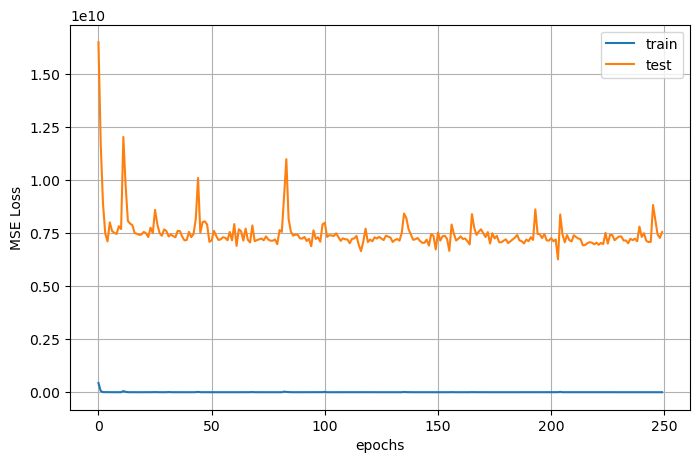

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid();

In [49]:
model_c2.eval()
with torch.no_grad():
    output = model_c2(X_test)

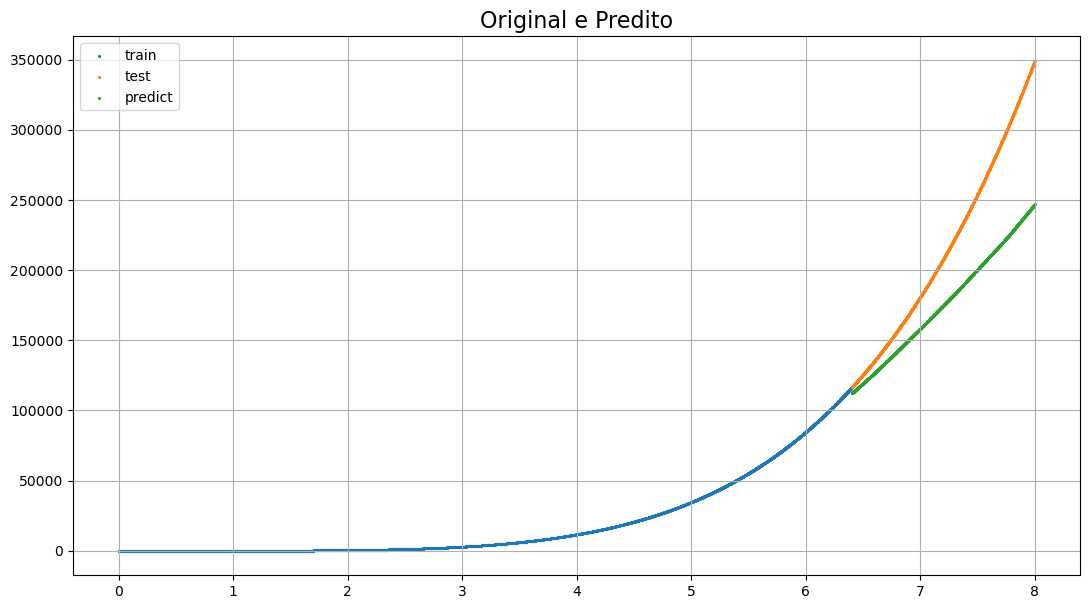

In [50]:
plt.figure(figsize=(13, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='o', s=1.5)
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='o', s=1.5)
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='predict', marker='o', s=1.5)
plt.legend()
plt.title("Original e Predito", fontsize=16)
plt.grid()

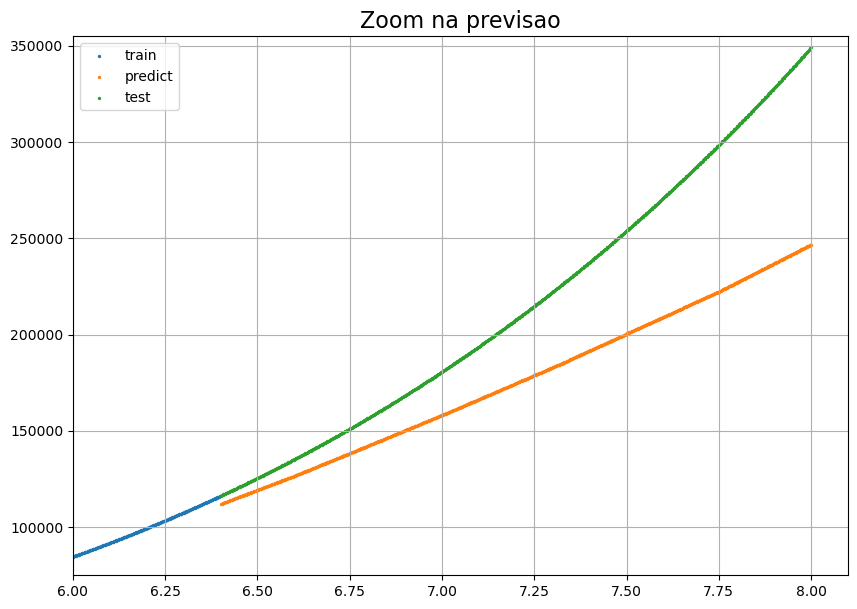

In [51]:
plt.figure(figsize=(10, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='o', s=2)
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='predict', marker='o', s=2)
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='o', s=2)
plt.legend()
plt.xlim(6, 8.1)
plt.ylim(7.5e4, 3.55e5)
plt.title("Zoom na previsao", fontsize=16)
plt.grid()

In [52]:
torch.sqrt(loss_fn(output, y_test))

tensor(87148.0547)


Epoch [250/250]: 100%|███████████████████████████████████████| 12500/12500 [03:18<00:00, 71.53it/s, loss=176342.562500]